In [14]:
# Adapting Efficientnet tutorial to emotion recognition
# https://www.kaggle.com/code/arjunrao2000/beginners-guide-efficientnet-with-keras
# Combined with Bhattiprolu, S. (2021, October 13). 239 - Deep Learning training for facial emotion detection [Video]. YouTube. https://www.youtube.com/watch?v=P4OevrwTq78&t=11s
import numpy as np
import pandas as pd
import os
from keras import applications
from tensorflow.keras.applications import EfficientNetB3
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from matplotlib import pyplot as plt

#Sets image dimensions and batch size
IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32

train_data_dir = 'data/train/'
test_data_dir = 'data/test/'

class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

#Only for training data
train_datagen = ImageDataGenerator(
                    rescale=1./255, #Rescales pixel values to 0,1 range
                    rotation_range=30, #Rotates image by up to 30 degrees
                    shear_range=0.3, 
                    zoom_range=0.3,
                    horizontal_flip=True, #Flip some images horizontally
                    fill_mode='nearest') #Fills pixels with nearest values

#Only for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(IMG_HEIGHT,IMG_WIDTH), #Images are resized
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True) #Shuffle data for randomness

test_generator = test_datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(48,48,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 7, activation='sigmoid'))

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

num_test_imgs = 0
for root, dirs, files in os.walk(test_data_dir):
    num_test_imgs += len(files)

num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
#Trains the model
history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//batch_size, #Calculates steps per epoch
                epochs=50,
                validation_data=test_generator, #Sets test_generator for validation
                validation_steps=num_test_imgs//batch_size)

#Saves model
model.save('efficientnet_model.h5')

#####################################

#plot the training and test accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Test the model
my_model = load_model('efficientnet_model.h5', compile=False)

#Generate a batch of images
test_img, test_lbl = test_generator.__next__()

#Predicts labels
predictions=my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 120)                 │         184,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 120)                 │          14,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 7)                   │             847 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,983,342 (41.90 MB)

 Trainable params: 10,896,039 (41.57 MB)

 Non-trainable params: 87,303 (341.03 KB)

Epoch 1/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 618s 635ms/step - accuracy: 0.3158 - loss: 0.3829 - val_accuracy: 0.2532 - val_loss: 0.4091
Epoch 2/50
  1/897 ━━━━━━━━━━━━━━━━━━━━ 6:59 468ms/step - accuracy: 0.5625 - loss: 0.2706

C:\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.5625 - loss: 0.2706 - val_accuracy: 0.2000 - val_loss: 0.3810
Epoch 3/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 456s 509ms/step - accuracy: 0.4648 - loss: 0.3159 - val_accuracy: 0.1716 - val_loss: 0.4260
Epoch 4/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step - accuracy: 0.5000 - loss: 0.2905 - val_accuracy: 0.2000 - val_loss: 0.4650
Epoch 5/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 477s 532ms/step - accuracy: 0.5116 - loss: 0.2940 - val_accuracy: 0.1738 - val_loss: 0.4276
Epoch 6/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 153us/step - accuracy: 0.2500 - loss: 0.3764 - val_accuracy: 0.2000 - val_loss: 0.4077
Epoch 7/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 471s 525ms/step - accuracy: 0.5350 - loss: 0.2834 - val_accuracy: 0.2469 - val_loss: 0.4082
Epoch 8/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 163us/step - accuracy: 0.6875 - loss: 0.2364 - val_accuracy: 0.4000 - val_loss: 0.3772
Epoch 9/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 460s 513ms/step - accuracy: 0.5525 - loss: 0.2733 - val

NameError: name 'plt' is not defined

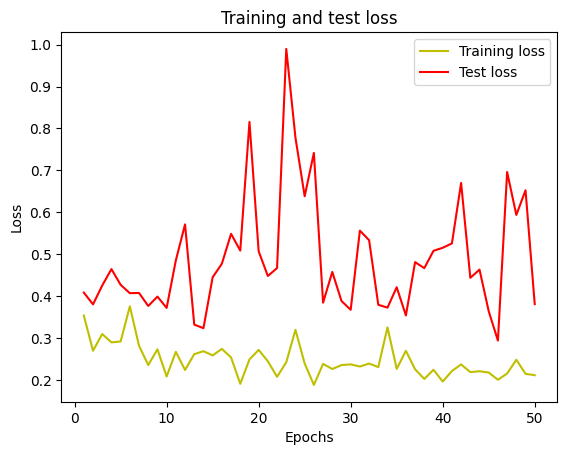

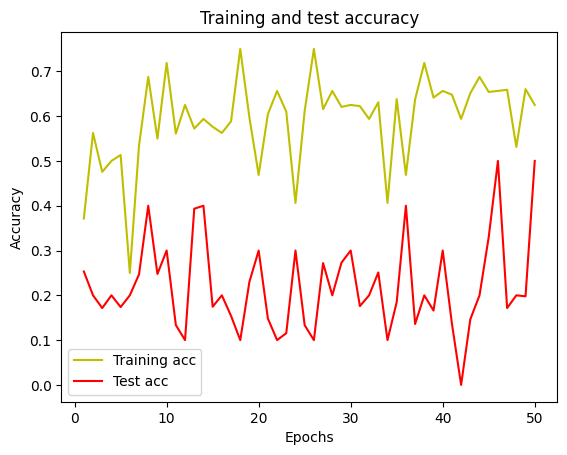

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Accuracy =  0.3125


NameError: name 'random' is not defined

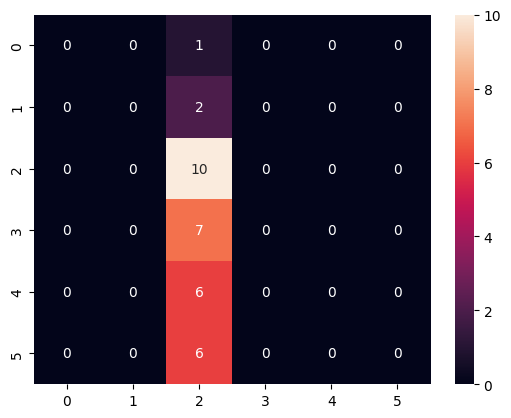